In [77]:
import mfem.ser as mfem
from mfem.common.arg_parser import ArgParser
import numpy as np
from glvis import glvis
import matplotlib.pyplot as plt
import mpi4py.MPI as MPI
print(MPI.Get_version())
import math
import h5py
import os

(4, 1)


In [121]:
def create_2D_mesh(nx, ny, x_start, x_end, y_start, y_end):
    """
    Creates a 2D mesh with the specified intervals and coordinate ranges.

    Args:
        nx (int): Number of intervals in the x-direction.
        ny (int): Number of intervals in the y-direction.
        x_start (float): Starting x-coordinate.
        x_end (float): Ending x-coordinate.
        y_start (float): Starting y-coordinate.
        y_end (float): Ending y-coordinate.

    Returns:
        mesh: The updated mesh with vertex coordinates set accordingly.
    """
    # Generate equally spaced coordinates for x and y
    x_coords = np.linspace(x_start, x_end, nx + 1)
    y_coords = np.linspace(y_start, y_end, ny + 1)
    
    # Create the mesh with initial x and y values set to 0 (they will be updated)
    mesh = mfem.Mesh(nx, ny, "QUADRILATERAL", True, 0.0, 0.0)
    
    # Retrieve the vertex array from the mesh
    verts = mesh.GetVertexArray()
    
    # Check if the number of vertices is as expected: (nx+1) * (ny+1)
    expected_num = (nx + 1) * (ny + 1)
    num_verts = mesh.GetNV()
    
    if num_verts != expected_num:
        print("Warning: Unexpected number of vertices! ({} != {})".format(num_verts, expected_num))
    
    # Update the vertex coordinates; vertices are stored in row-major order
    k = 0
    for j in range(ny + 1):
        for i in range(nx + 1):
            verts[k][0] = x_coords[i]
            verts[k][1] = y_coords[j]
            k += 1
    
    return mesh

def gauss_legendre_dirs(N_dir):
    """
    Compute Gauss-Legendre quadrature points (mu_i) and weights (w_i)
    for discrete ordinates. Typically used for [-1,1].
    Returns (mu[], w[]) each of length N_dir.
    """
    mu = []
    w  = []

    gg_mu, gg_w = np.polynomial.legendre.leggauss(N_dir)
    
    mu = gg_mu.tolist()
    w  = gg_w.tolist()
    return mu, w

def read_data(nE):
    """
    Read cross-section and stopping power data from an HDF5 file.

    Expects datasets "xs_t_{nE}", "xs_s_{nE}", and "S_{nE}".

    Args:
        nE (int): Number of energy groups.

    Returns:
        tuple: (xs_t_arr, xs_s_arr, S_arr) as numpy arrays.
    """
    data_file = "data.h5"

    with h5py.File(data_file, "r") as f:
        E_arr = f[f"E_{nE}"][:]
        E_grid_arr = f[f"E_{nE}"][:]
        xs_t_arr = f[f"xs_t_{nE}"][:]
        xs_s_arr = f[f"xs_s_{nE}"][:]
        S_arr    = f[f"S_{nE}"][:]
        
    return E_arr, E_grid_arr, xs_t_arr, xs_s_arr, S_arr

class TotalXSCoefficient(mfem.PyCoefficient):
    """
    Coefficient for the total cross-section Σ_t(E).

    Maps the normalized energy coordinate (x[1]) in [0,1] to the corresponding 
    cross-section value. Here, y=0 corresponds to E = E_start and y=1 corresponds to 
    E = E_end.
    """
    def __init__(self, xs_t_data, E_start, E_end):
        super(TotalXSCoefficient, self).__init__()
        self.xs_t_data = xs_t_data
        self.E_start = E_start
        self.E_end = E_end

    def EvalValue(self, x):
        y = x[1] 
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.xs_t_data)
        group = min(n_groups - 1, int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.xs_t_data[group])
    
class ScatteringXSCoefficient(mfem.PyCoefficient):
    """
    Coefficient for the scattering cross-section Σ_s(E).

    Maps the normalized energy coordinate (x[1]) in [0,1] to the corresponding 
    scattering cross-section value. Here, y=0 corresponds to E = E_start and y=1 
    corresponds to E = E_end.
    """
    def __init__(self, xs_s_data, E_start, E_end):
        super(ScatteringXSCoefficient, self).__init__()
        self.xs_s_data = xs_s_data
        self.E_start = E_start
        self.E_end = E_end

    def EvalValue(self, x):
        y = x[1]
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.xs_s_data)
        group = min(n_groups - 1, int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.xs_s_data[group])

class StoppingPowerCoefficient(mfem.PyCoefficient):
    """
    Coefficient for the stopping power S(E).

    Maps the normalized energy coordinate (x[1]) in [0,1] to the corresponding 
    S(E) value. Here, y=0 corresponds to E = E_start and y=1 corresponds to 
    E = E_end.
    """
    def __init__(self, S_data, E_start, E_end):
        super(StoppingPowerCoefficient, self).__init__()
        self.S_data = S_data
        self.E_start = E_start
        self.E_end = E_end

    def EvalValue(self, x):
        y = x[1]
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.S_data)
        group = min(n_groups - 1, int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.S_data[group])
    
class StoppingPowerDerivativeCoefficient(mfem.PyCoefficient):
    """
    Coefficient for the derivative of the stopping power S(E), i.e., S'(E).

    Maps the normalized energy coordinate (x[1]) in [0,1] to the corresponding 
    derivative value. Here, y=0 corresponds to E = E_start and y=1 corresponds to 
    E = E_end.
    """
    def __init__(self, dS_data, E_start, E_end):
        super(StoppingPowerDerivativeCoefficient, self).__init__()
        self.dS_data = dS_data
        self.E_start = E_start
        self.E_end = E_end

    def EvalValue(self, x):
        y = x[1]
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.dS_data)
        group = min(n_groups - 1, int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.dS_data[group])
    
class InflowCoefficient(mfem.PyCoefficient):
    """
    Coefficient for the inflow boundary condition.
    Returns a prescribed inflow flux value.
    """
    def __init__(self, inflow_value):
        super(InflowCoefficient, self).__init__()
        self.inflow_value = inflow_value

    def EvalValue(self, x):
        return self.inflow_value
    

class QCoefficient(mfem.PyCoefficient):
    """
    Coefficient for the source term Q(x,E).

    Maps the normalized energy coordinate (x[1] in [0,1]) to the corresponding 
    Q value. Here, y=0 corresponds to E = E_start and y=1 corresponds to E = E_end.
    
    If Q_data is given as the scalar 0, then the coefficient always returns 0,
    and E_start and E_end are not required.
    """
    def __init__(self, Q_data, E_start=None, E_end=None):
        super(QCoefficient, self).__init__()

        if isinstance(Q_data, (int, float)) and Q_data == 0:
            self.scalar_zero = True
            self.Q_data = None

        else:

            if E_start is None or E_end is None:
                raise ValueError("For non-zero Q_data, E_start and E_end must be provided.")
            self.scalar_zero = False
            if isinstance(Q_data, (int, float)):

                self.Q_data = [Q_data]
            else:
                self.Q_data = Q_data
            self.E_start = E_start
            self.E_end = E_end

    def EvalValue(self, x):
        if self.scalar_zero:
            return 0.0
        
        y = x[1]
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.Q_data)
        group = min(n_groups - 1, int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))

        return float(self.Q_data[group])



inflow_coef = InflowCoefficient(inflow_value)
b = mfem.LinearForm(fes)
q_coef = QCoefficient(0)
b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coef))
b.Assemble()


ValueError: x and y must have same first dimension, but have shapes (51,) and (50,)

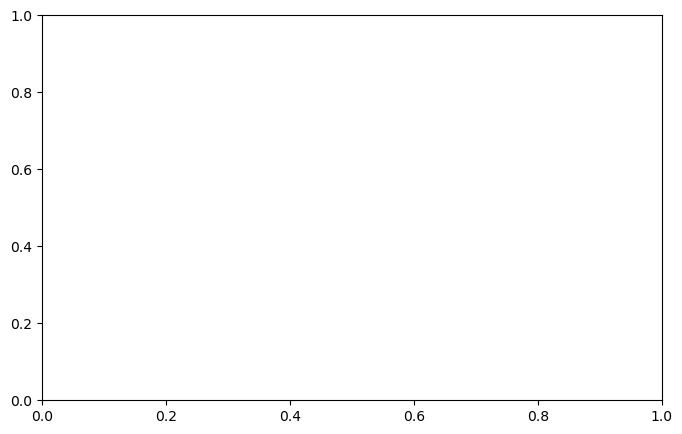

In [100]:
import numpy as np
import matplotlib.pyplot as plt

def compute_stopping_power_derivative(E_start, E_end, n_groups, S_data):
    """
    Divides the energy range [E_start, E_end] into n_groups, computes the group boundaries and centers,
    and then calculates the derivative dS/dE using a finite difference approach based on the provided S_data.
    
    Args:
        E_start (float): Highest energy (e.g., 1.0 MeV)
        E_end (float): Lowest energy (e.g., 0.01 MeV)
        n_groups (int): Number of energy groups (e.g., 50)
        S_data (ndarray): Stopping power values at each group center (array of length n_groups)
    
    Returns:
        centers (ndarray): Array of energy values at the center of each group.
        ds_data (ndarray): Finite difference approximation of dS/dE at each group center.
        boundaries (ndarray): Array of energy group boundaries.
    """
    # Compute the energy group boundaries
    boundaries = np.linspace(E_start, E_end, n_groups + 1)
    
    # Initialize the derivative array
    ds_data = np.zeros(n_groups + 1)
    
    # Use forward difference for the first group
    ds_data[0] = (S_data[1] - S_data[0]) / (centers[1] - centers[0])
    
    # Use central difference for groups in the middle
    for i in range(1, n_groups - 1):
        ds_data[i] = (S_data[i + 1] - S_data[i - 1]) / (centers[i + 1] - centers[i - 1])
    
    # Use backward difference for the last group
    ds_data[-1] = (S_data[-1] - S_data[-2]) / (centers[-1] - centers[-2])
    
    return centers, ds_data, boundaries

# Example usage:
if __name__ == "__main__":

    # Compute the derivative dS/dE for each energy group
    centers, ds_data, boundaries = compute_stopping_power_derivative(1, 0.01, 50, S_vals)

    # Plot the computed derivative
    plt.figure(figsize=(8, 5))
    plt.plot( ds_data, centers, marker='o')
    plt.xlabel("Energy (MeV)")
    plt.ylabel("dS/dE (MeV/cm per MeV)")
    plt.title("Finite Difference Derivative of Stopping Power")
    plt.grid(True)
    plt.show()


Normalized y = 0.00, Energy E = 1.000 MeV, Coefficient = 0.000
Normalized y = 0.10, Energy E = 0.901 MeV, Coefficient = 0.000
Normalized y = 0.20, Energy E = 0.802 MeV, Coefficient = 0.000
Normalized y = 0.30, Energy E = 0.703 MeV, Coefficient = 0.000
Normalized y = 0.40, Energy E = 0.604 MeV, Coefficient = 0.000
Normalized y = 0.50, Energy E = 0.505 MeV, Coefficient = 0.000
Normalized y = 0.60, Energy E = 0.406 MeV, Coefficient = 0.000
Normalized y = 0.70, Energy E = 0.307 MeV, Coefficient = 0.000
Normalized y = 0.80, Energy E = 0.208 MeV, Coefficient = 0.000
Normalized y = 0.90, Energy E = 0.109 MeV, Coefficient = 0.000
Normalized y = 1.00, Energy E = 0.010 MeV, Coefficient = 0.000


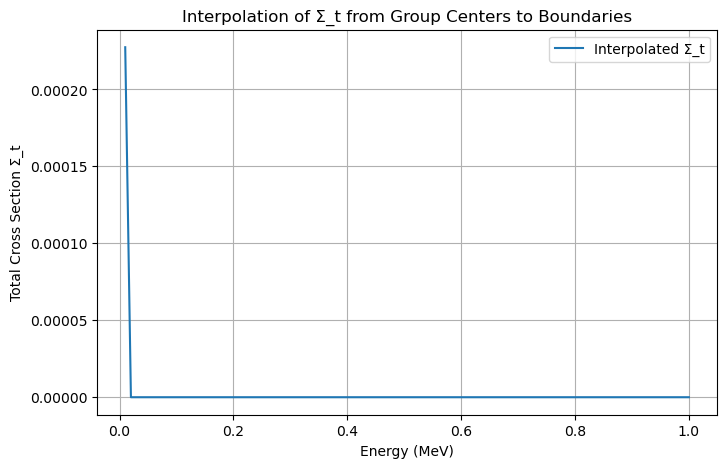

In [106]:
import numpy as np
import mfem.ser as mfem

class TotalXSCoefficient(mfem.PyCoefficient):
    """
    Coefficient for the total cross-section Σ_t(E).

    Maps the normalized energy coordinate (x[1]) in [0,1] to the corresponding 
    cross-section value using linear interpolation.
    
    The normalized coordinate y is mapped to energy:
        E = E_start + y*(E_end - E_start)
    where E_start is the highest energy and E_end is the lowest energy.
    
    The xs_t_data array (of length 50) is assumed to be defined at the centers 
    of the 50 energy groups. This class interpolates these values onto the 51 
    energy boundary points (derived from E_start and E_end) and then returns the 
    interpolated value corresponding to energy E.
    """
    def __init__(self, xs_t_data, E_start, E_end):
        super(TotalXSCoefficient, self).__init__()
        self.xs_t_data = xs_t_data
        self.E_start = E_start
        self.E_end = E_end
        # Pre-compute group boundaries (51 points) and group centers (50 points)
        self.n_groups = len(xs_t_data)
        self.boundaries = np.linspace(self.E_start, self.E_end, self.n_groups + 1)
        self.centers = 0.5 * (self.boundaries[:-1] + self.boundaries[1:])

    def EvalValue(self, x):
        y = x[1]  # normalized energy coordinate in [0,1]
        # Map y ∈ [0,1] to energy E ∈ [E_start, E_end]
        E = self.E_start + y * (self.E_end - self.E_start)
        # Perform linear interpolation: if E is outside the centers, use endpoint values.
        value = np.interp(E, self.centers, self.xs_t_data, 
                          left=self.xs_t_data[0], right=self.xs_t_data[-1])
        return float(value)

# Example usage:
if __name__ == "__main__":
    # Suppose we have 50 stopping power values defined at group centers.
    n_groups = 50
    E_start = 1.0    # Highest energy (MeV)
    E_end = 0.01     # Lowest energy (MeV)
    data = h5py.File("data.h5", "r")
    xs_t_vals = data[f"xs_t_{nE}"][:]
    xs_t_data = xs_t_vals
    # Create an instance of the coefficient
    coeff = TotalXSCoefficient(xs_t_data, E_start, E_end)
    
    test_ys = np.linspace(0, 1, 11)
    for y in test_ys:
        # Construct a coordinate: x[0] is not used here; x[1] is the normalized energy coordinate
        x_coord = [0.0, y]
        val = coeff.EvalValue(x_coord)
        # Map normalized y to energy E
        E = E_start + y*(E_end - E_start)
        print("Normalized y = {:.2f}, Energy E = {:.3f} MeV, Coefficient = {:.3f}".format(y, E, val))

    # (Optional) Plot the interpolated coefficient values over the energy range.
    energies = np.linspace(E_start, E_end, 100)
    coeff_values = [coeff.EvalValue([0.0, (E - E_start)/(E_end - E_start)]) for E in energies]
    plt.figure(figsize=(8, 5))
    plt.plot(energies, coeff_values, label="Interpolated Σ_t")
    plt.xlabel("Energy (MeV)")
    plt.ylabel("Total Cross Section Σ_t")
    plt.title("Interpolation of Σ_t from Group Centers to Boundaries")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:

nx = 20
nE = 50
x_start = 0.0
x_end = 0.3
E_start = 1.0
E_end = 0.01
N_ang = 8
mu_vals, w_vals = np.polynomial.legendre.leggauss(N_ang)
order = 1

mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()
print(dim)
inflow_value = 1.0


fec = mfem.DG_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
ndofs = fes.GetVSize()
print(f"Number of finite element unknowns:: {ndofs}")
a = mfem.BilinearForm(fes)


ess_tdof_list = mfem.intArray()
dir_bdr = mfem.intArray(mesh.bdr_attributes.Max())
dir_bdr.Assign(1)
dir_bdr.Size()

print(dir_bdr.Size())
print(ess_tdof_list.Size())



2
Number of finite element unknowns:: 4000
4
0


In [125]:
E, E_grid_arr, xs_t_arr, xs_s_arr, S = read_data(50)

def compute_derivative(E, S):
    """
    Compute the derivative dS/dE using finite differences.
    
    Args:
        E (ndarray): 1D array of energy values.
        S (ndarray): 1D array of S values corresponding to the energies.
    
    Returns:
        dS_dE (ndarray): Array of the finite difference approximation of the derivative dS/dE.
    """
    n = len(E)
    dS_dE = np.zeros(n)
    
    # Forward difference for the first point
    dS_dE[0] = (S[1] - S[0]) / abs(E[1] - E[0])
    
    # Central difference for interior points
    for i in range(1, n - 1):
        dS_dE[i] = (S[i + 1] - S[i - 1]) / abs(E[i + 1] - E[i - 1])
    
    # Backward difference for the last point
    dS_dE[-1] = (S[-1] - S[-2]) / abs(E[-1] - E[-2])
    
    return dS_dE

# Example usage:
if __name__ == '__main__':
    # Generate 51 energy values from 1.0 to 0.01 (inclusive)

    # Define S as an example function of E, e.g., S(E) = 0.5 * E + 0.1
    E, E_grid_arr, xs_t_arr, xs_s_arr, S = read_data(50)
    # Compute the derivative dS/dE
    dS_dE = compute_derivative(E, S)
    
    # Print the results
    print("Energy values (E):")
    print(E)
    print("\nS values:")
    print(S)
    print("\ndS/dE values:")
    print(dS_dE)


IndexError: index 50 is out of bounds for axis 0 with size 50